In [4]:
from numpy import exp, sqrt, log, linspace
from random import gauss
import pandas as pd
import matplotlib.pyplot as plt



In [5]:
#Generate stock path, but increase vol if stock falls below certain threshold

nsims = 1000
stpx = 100
days = 253
rf = .02
mainframe = pd.DataFrame(0, index = list(range(1,days)), columns = list(range(1,nsims)))
mainframe.iloc[0] = stpx
for i in range(0, nsims-1):
    for x in range(1, days-1):
        if mainframe.iloc[x-1, i] <90:
            sigma = .90
        else: 
            sigma = .15
        mainframe.iloc[x, i] = mainframe.iloc[x-1, i] *exp((rf - (.5*sigma**2))*(1/252)+sigma*sqrt(1/252)*gauss(0,1))

        

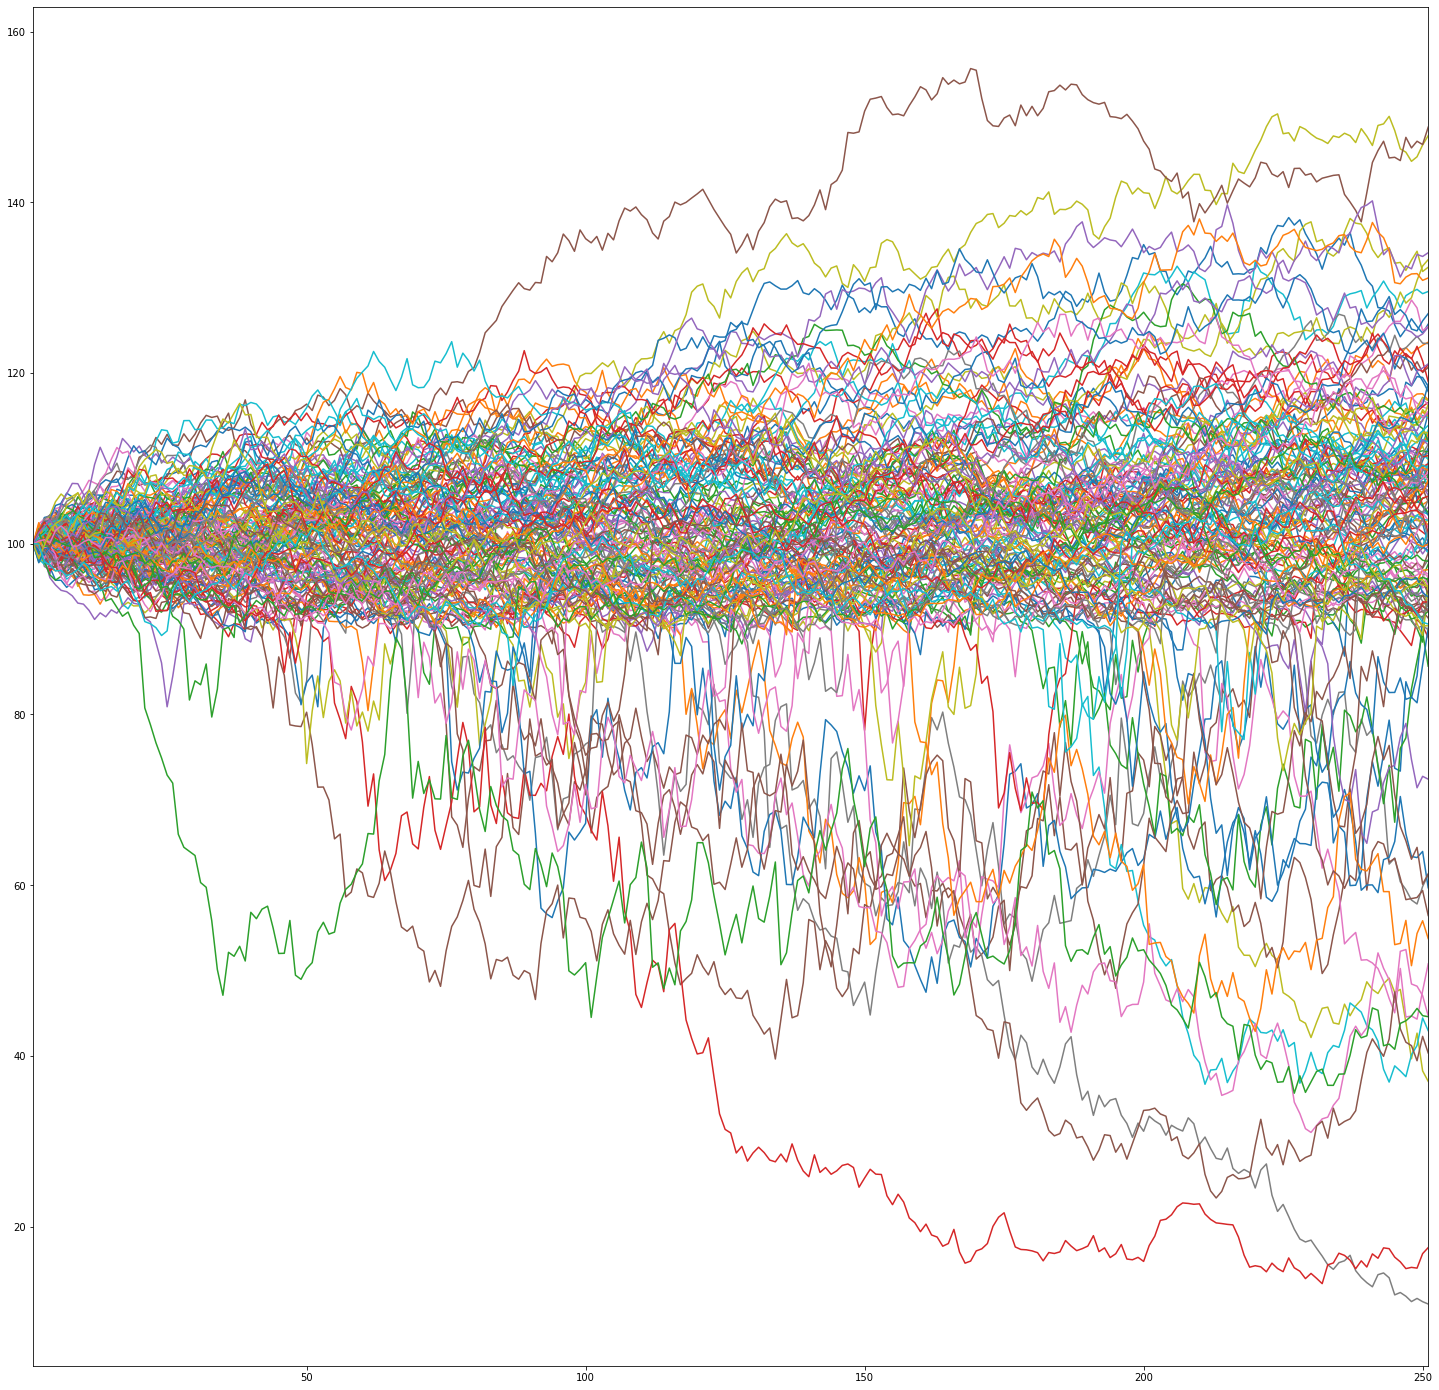

In [7]:
mainframe.iloc[0:-1, 150:300].plot(legend = False, figsize =(25,25))
plt.show()



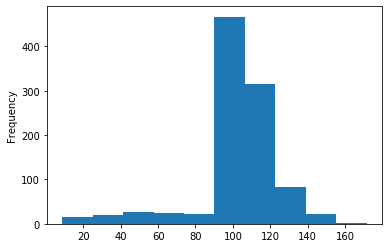

(252, 999)

In [17]:
mainframe.iloc[-1].plot.hist()
plt.show()

mainframe.shape

In [9]:
std = pd.DataFrame(0, index = list(range(1,mainframe.shape[0])), columns =list(range(1,mainframe.shape[1]+1)))
for n in range(0, mainframe.shape[1]):
    for z in range(0, mainframe.shape[0]-1):
        std.iloc[z,n] = (mainframe.iloc[z+1,n] - mainframe.iloc[z,n])/mainframe.iloc[z,n]


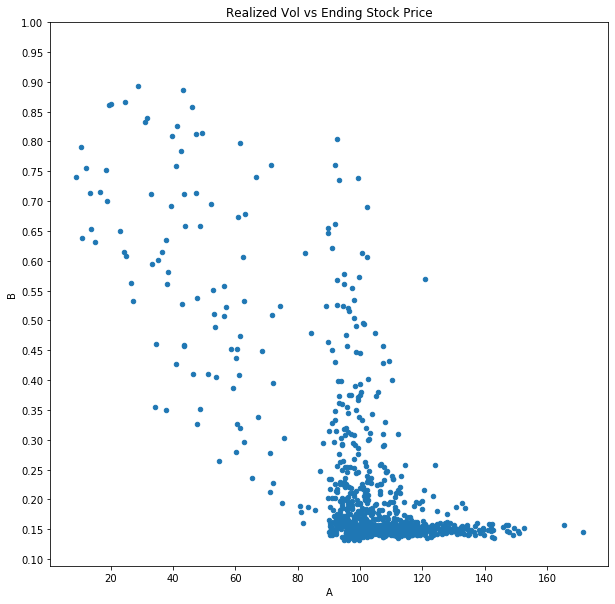

In [20]:
#Generate scatterplot of realized vol vs ending stock price

vol = pd.DataFrame(0, index = [1,2], columns = list(range(1, std.shape[1]+1)))
for m in range(0, std.shape[1]):
    vol.iloc[0,m] = std.iloc[:,m].std()*sqrt(252)
vol.iloc[-1] = mainframe.iloc[-1]
plot = pd.DataFrame(0, index = list(range(1,nsims)), columns = ['A','B'])
plot.iloc[0:,0] = vol.iloc[-1]
plot.iloc[0:,1] = vol.iloc[0]
scatter = plot.plot.scatter(x = 'A', y = 'B', figsize = (10,10), yticks = linspace(.1, 1, 19), title = 'Realized Vol vs Ending Stock Price')
plt.show()



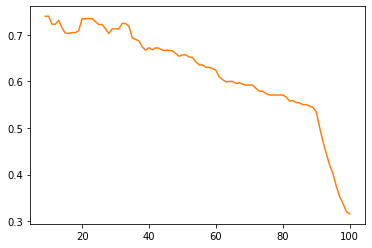

In [26]:
import warnings
warnings.filterwarnings('ignore')
testcall = vol.copy(deep = True)
strikpay = [ 1 for x in range(100,5,-5) ]
listy = [1 for x in range(1,10)]

pay = []
strike = []
skewvol = []
dlta = []
for Strike in range(100,5,-1):
    clvol = vol.copy(deep = True)
    payoff = (Strike -(clvol.iloc[1,:] [clvol.iloc[1,:] <Strike])).sum()/clvol.shape[1]
    pay.append(payoff)
    dlta.append(sum(sum([testcall.iloc[1,:]<Strike]))/clvol.shape[1])
    clvol.iloc[0,:][clvol.iloc[1,:]>=Strike] = 0
    clvol.iloc[1,:] [clvol.iloc[1,:]<Strike] = 1
    clvol.iloc[1,:] [clvol.iloc[1,:]>=Strike] = 0
    averagevol = clvol.iloc[0,:].sum()/clvol.iloc[1,:].sum()
    skewvol.append(averagevol)
    strike.append(Strike)



plt.plot(strike,skewvol)
plt.show()

#Graph vol skew


In [ ]:
vol.iloc[0].hist(bins = 200, normed = True, figsize = (10, 10), 'Realized Volatility Distribution')
plt.show()

In [27]:
#Calculate IV
from scipy.stats import norm
from scipy.optimize import root
import numpy as np

N = norm(0,1).cdf
n = norm(0,1).pdf


def bs(S, X, r, sigma, T):
    d1 = np.log(S/X)+(r+0.5*sigma*sigma)*T
    d1 = d1/sigma/np.sqrt(T+1E-10)
    d2 = d1 -sigma*np.sqrt(T)
    return S*N(d1) -X*np.exp(r*T)*N(d2) +X-S



from scipy.optimize import root

def iv(S, X, r, T, C):
    return root(lambda s: bs(S, X, r, s, T)-C,.50)
                
deltas =[]
ivs = []
ivsfloat = []
masterlist = [ [] for x in strike]
for index, item in enumerate(pay):
    vss = iv(100,strike[index], 0.00, 1, item )
    ivs.append(float(vss.x))
    ivsfloat.append(float(vss.x))
    masterlist[index].append([strike[index], pay[index], float(vss.x), skewvol[index], dlta[index]])
    
    
std = pd.DataFrame(0, index = list(range(1,mainframe.shape[0])), columns =list(range(1,mainframe.shape[1]+1)))   
outputframe = pd.DataFrame(0, index = list(range(0,len(strike))), columns = ['Strike', 'Price', 'IV', 'AvgVol', 'Prob'])
outputframe['Strike'] =strike
outputframe.iloc[:,1] = pay
outputframe.iloc[:,2] = ivs
outputframe.iloc[:,3] = skewvol
outputframe.iloc[:,4] = dlta

outputframe

,Strike,Price,IV,AvgVol,Prob
0,100,6.255456,0.156962,0.315441,0.372372
1,99,5.899719,0.161085,0.320353,0.346346
2,98,5.575150,0.165440,0.338150,0.304304
3,97,5.289480,0.170277,0.352654,0.271271
4,96,5.033493,0.175417,0.375187,0.236236
5,95,4.817756,0.181199,0.401928,0.203203
6,94,4.626717,0.187278,0.420520,0.180180
7,93,4.458721,0.193663,0.445435,0.157157
8,92,4.311325,0.200342,0.471274,0.136136
9,91,4.184494,0.207364,0.502081,0.118118


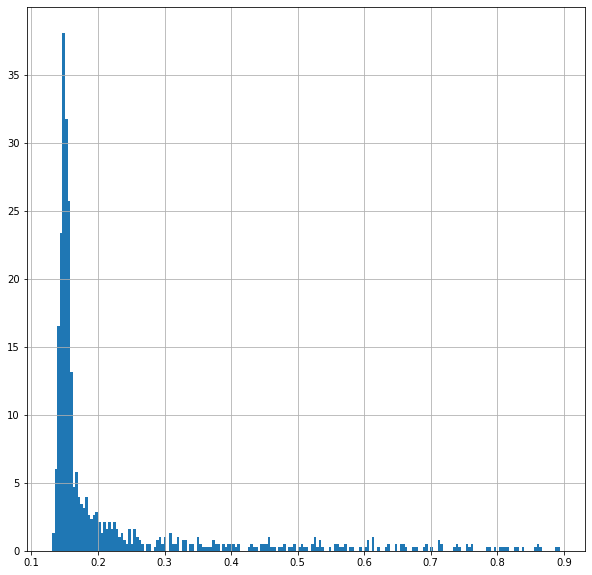

In [30]:
vol.iloc[0].hist(bins = 200, normed = True, figsize = (10, 10), 'Realized Volatility Distribution')
plt.show()

In [31]:
plot.sort_values('B', ascending = False)

vol.iloc[0].mean()

0.22418613651205715